Optimizing tetrahedra...

Quality Metrics Summary:

Tetrahedron 1:
Initial metrics:
aspect_ratio: 2.239
scaled_jacobian: 0.336
shape: 0.614

Final metrics:
aspect_ratio: 1.000
scaled_jacobian: 1.000
shape: 1.000

Tetrahedron 2:
Initial metrics:
aspect_ratio: 2.669
scaled_jacobian: -0.313
shape: 0.000

Final metrics:
aspect_ratio: 1.000
scaled_jacobian: -1.000
shape: 0.000

Tetrahedron 3:
Initial metrics:
aspect_ratio: 84.240
scaled_jacobian: 0.004
shape: 0.040

Final metrics:
aspect_ratio: 1.000
scaled_jacobian: -1.000
shape: 0.000


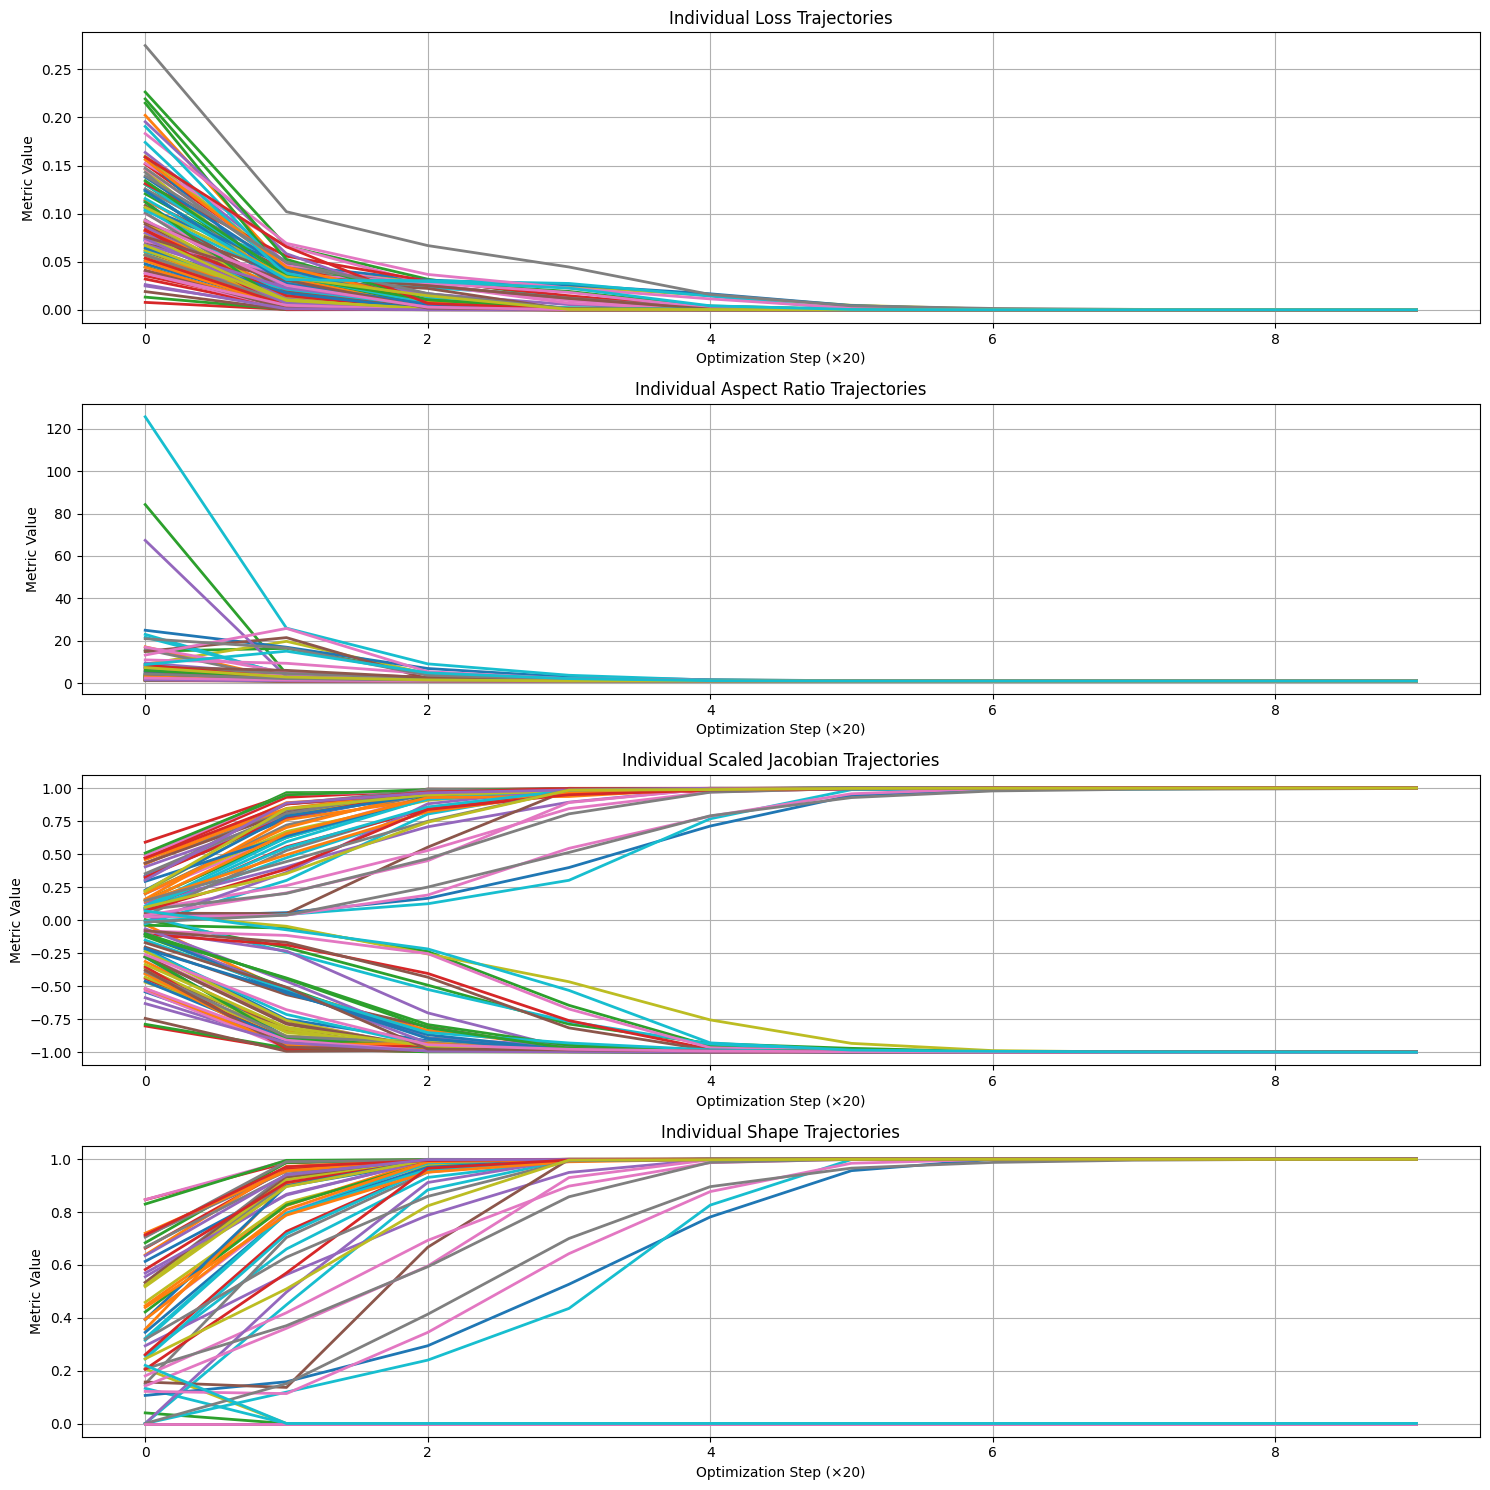

In [31]:
import torch
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt
from torch.optim import Adam
import meshio


def wellShapedLoss(nodes, index_a, index_b, initial_volumes=None):
    nodes_a = nodes[:, index_a, :]
    nodes_b = nodes[:, index_b, :]
    edges = nodes_a - nodes_b
    
    ### Edge length
    lengths = torch.norm(edges, dim=2)
    mean_length = torch.mean(lengths, axis=1).unsqueeze(1)
    a = (lengths - mean_length) / (mean_length + 1e-15)
    edge_loss_value = torch.mean(a ** 2)

    return edge_loss_value, a**2, None

def generate_random_tetrahedra(num_samples=100):
    """
    Generate completely random tetrahedra
    """
    # Create random points in a circumscribed cube
    nodes = torch.rand(num_samples, 4, 3) * 2 - 1
    
    return nodes

def create_tet_mesh(vertices):
    """
    Create a PyVista UnstructuredGrid from tetrahedral vertices
    Tetrahedra are defined by 4 vertices each, not connected to each other
    """
    
    # Create a PyVista mesh
    N = vertices.shape[0]
    
    vertices = vertices.reshape(-1, 3)
    
    cells = np.arange(N*4).reshape(N, 4)    
    mesh = meshio.Mesh(
        points=vertices, cells=[("tetra", cells)]
    )
    
    meshio.write("temp.vtk", mesh)
    
    grid = pv.read("temp.vtk")
    
    return grid

def compute_quality_metrics(vertices):
    """
    Compute all PyVista quality metrics for tetrahedra
    """
    mesh = create_tet_mesh(vertices)
    
    metrics = {}
    for measure in ['aspect_ratio', 'scaled_jacobian', 'shape']:
        quality = mesh.compute_cell_quality(quality_measure=measure)["CellQuality"]
        metrics[measure] = quality
    return metrics


def optimize_tetrahedra(initial_nodes, num_steps=1000, lr=0.01):
    """
    Optimize tetrahedra using gradient descent on well-shaped loss
    """
    nodes = initial_nodes.clone().detach().requires_grad_(True)
    optimizer = Adam([nodes], lr=lr)
    index_a = torch.tensor([0,0,0,1,1,2])
    index_b = torch.tensor([1,2,3,2,3,3])
    
    # Track progress more frequently
    loss_history = []
    node_history = []
    
    # Initialize quality history for each tetrahedron
    num_tets = len(initial_nodes)
    tet_quality_history = {
        'loss': [[] for _ in range(num_tets)],
        'aspect_ratio': [[] for _ in range(num_tets)],
        'scaled_jacobian': [[] for _ in range(num_tets)],
        'shape': [[] for _ in range(num_tets)]
    }
    volumes = None
    # Optimization loop
    for step in range(num_steps):
        optimizer.zero_grad()
        loss, individual_loss, volumes = wellShapedLoss(nodes, index_a, index_b, volumes)
        
        # Store metrics more frequently (every 20 steps)
        if step % 20 == 0:
            loss_history.append(loss.item())
            node_history.append(nodes.detach().clone())
            
            # Compute quality metrics for all tetrahedra
            metrics = compute_quality_metrics(nodes.detach().numpy())
            
            # Store individual tetrahedron metrics
            for metric_name, values in metrics.items():
                if metric_name in ['aspect_ratio', 'scaled_jacobian', 'shape']:
                    for i, value in enumerate(values):
                        tet_quality_history[metric_name][i].append(value)

            per_tetrahedron_loss = individual_loss.mean(axis=1).detach().numpy()
            for i in range(num_tets):
                tet_quality_history['loss'][i].append(per_tetrahedron_loss[i])
                
        loss.backward()
        optimizer.step()
    
    return nodes, loss_history, tet_quality_history, node_history

def visualize_individual_tetrahedra(tet_quality_history, num_tets_to_show=5):
    """
    Visualize quality metrics for individual tetrahedra over time
    """
    metrics = ['loss', 'aspect_ratio', 'scaled_jacobian', 'shape']
    plt.figure(figsize=(15, 15))
        
    for idx, metric in enumerate(metrics, 1):
        plt.subplot(4, 1, idx)
        
        # Plot individual trajectories for selected tetrahedra
        for i in range(min(num_tets_to_show, len(tet_quality_history[metric]))):
            history = tet_quality_history[metric][i]
            plt.plot(history, label=f'Tetrahedron {i+1}', linewidth=2)
        
        plt.title(f'Individual {metric.replace("_", " ").title()} Trajectories')
        plt.xlabel('Optimization Step (×20)')
        plt.ylabel('Metric Value')
        plt.grid(True)
        #plt.legend()
    
    plt.tight_layout()
    plt.show()

def analyze_optimization():
    # Generate random initial tetrahedra
    num_samples = 100
    initial_nodes = generate_random_tetrahedra(num_samples)
    
    # Optimize tetrahedra
    print("Optimizing tetrahedra...")
    final_nodes, loss_history, tet_quality_history, node_history = optimize_tetrahedra(
        initial_nodes, num_steps=200, lr=0.01
    )
    
    # Print initial and final metrics for first few tetrahedra
    print("\nQuality Metrics Summary:")
    initial_metrics = compute_quality_metrics(initial_nodes[:3].detach().numpy())
    final_metrics = compute_quality_metrics(final_nodes[:3].detach().numpy())
    
    for i in range(3):
        print(f"\nTetrahedron {i+1}:")
        print("Initial metrics:")
        for metric, values in initial_metrics.items():
            if metric in ['aspect_ratio', 'scaled_jacobian', 'shape']:
                print(f"{metric}: {values[i]:.3f}")
        
        print("\nFinal metrics:")
        for metric, values in final_metrics.items():
            if metric in ['aspect_ratio', 'scaled_jacobian', 'shape']:
                print(f"{metric}: {values[i]:.3f}")
        
    # Visualize individual tetrahedra trajectories
    visualize_individual_tetrahedra(tet_quality_history, num_tets_to_show=100)
    
    return initial_nodes, final_nodes, loss_history, tet_quality_history

# Run the analysis
initial_nodes, final_nodes, loss_history, tet_quality_history = analyze_optimization()


Initial Mesh Statistics:
Total Volume: 192214.12

Quality Metrics:
aspect_ratio:
  Mean: 27.950 ± 8797.960
  Range: [1.032, 5506674.746]
scaled_jacobian:
  Mean: 0.263 ± 0.256
  Range: [-0.961, 0.979]
shape:
  Mean: 0.480 ± 0.286
  Range: [0.000, 0.997]
Step 300/301, Loss: 0.0811

Final Mesh Statistics:
Total Volume: 192259.60

Quality Metrics:
aspect_ratio:
  Mean: 16.107 ± 2695.803
  Range: [1.019, 1574850.417]
scaled_jacobian:
  Mean: 0.282 ± 0.308
  Range: [-0.987, 0.980]
shape:
  Mean: 0.519 ± 0.296
  Range: [0.000, 0.997]


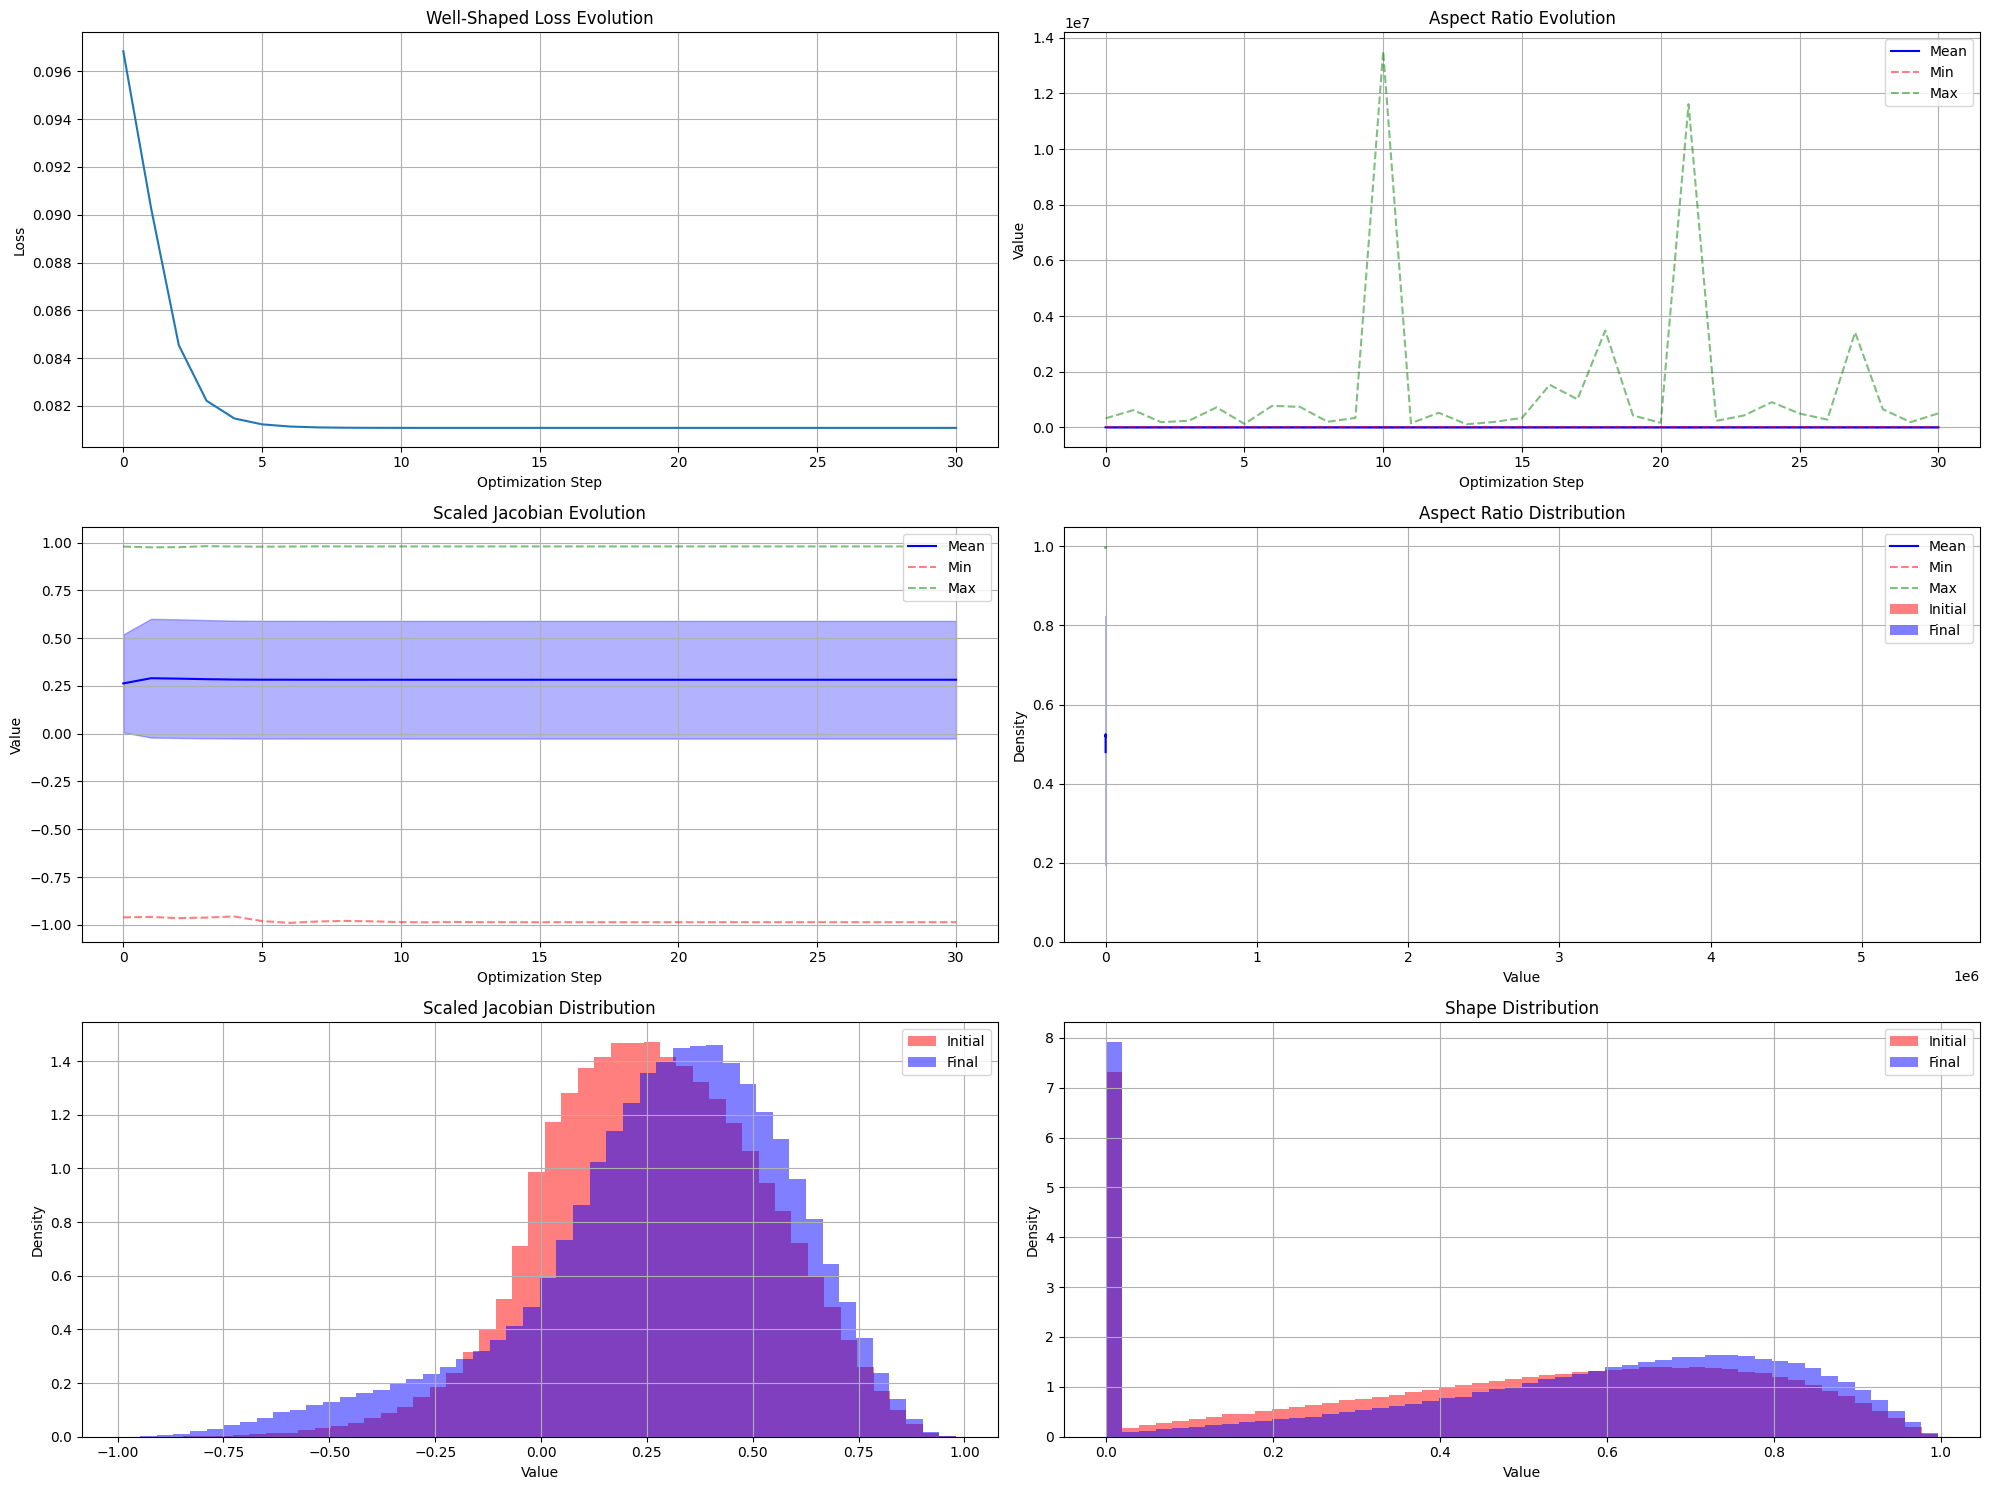

In [32]:
import torch
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt
from torch.optim import Adam
from pytorch3d.loss import chamfer_distance

def get_device():
    """
    Get the best available device (CUDA GPU if available, else CPU)
    """
    return torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def wellShapedLoss(nodes, index_a, index_b):
    # Original edge calculations
    nodes_a = nodes[:, index_a, :]
    nodes_b = nodes[:, index_b, :]
    edges = nodes_a - nodes_b
    lengths = torch.norm(edges, dim=3)
    mean_length = torch.mean(lengths, axis=2).unsqueeze(2)
    a = (lengths - mean_length) / (mean_length + 1e-15)
    edge_loss_value = torch.mean(a ** 2)

    return edge_loss_value

def compute_quality_metrics(vertices, tets):
    """
    Compute all PyVista quality metrics for tetrahedra
    """
    # Move data to CPU if it's on GPU
    if isinstance(vertices, torch.Tensor):
        vertices = vertices.detach().cpu().numpy()
    if isinstance(tets, torch.Tensor):
        tets = tets.detach().cpu().numpy()
        
    mesh = create_tet_mesh(vertices, tets)
    metrics = {}
    for measure in ['aspect_ratio', 'scaled_jacobian', 'shape']:
        quality = mesh.compute_cell_quality(quality_measure=measure)["CellQuality"]
        metrics[measure] = quality
    return metrics

def create_tet_mesh(vertices, tets):
    """
    Create a PyVista UnstructuredGrid from tetrahedral vertices and connectivity
    """
    # Move data to CPU if it's on GPU
    if isinstance(vertices, torch.Tensor):
        vertices = vertices.detach().cpu().numpy()
    if isinstance(tets, torch.Tensor):
        tets = tets.detach().cpu().numpy()
        
    mesh = meshio.Mesh(
        points=vertices, 
        cells=[("tetra", tets)]
    )
    meshio.write("temp.vtk", mesh)
    grid = pv.read("temp.vtk")
    return grid


def analyze_mesh_metrics(points, tets):
    """
    Compute and analyze mesh quality metrics and volume properties
    """
    metrics = compute_quality_metrics(points, tets)
    
    # Compute volumes of all tetrahedra
    mesh = create_tet_mesh(points, tets)
    cell_volumes = mesh.compute_cell_sizes(length=False, area=False, volume=True)['Volume']
    
    analysis = {
        'total_volume': np.sum(cell_volumes),
        'min_volume': np.min(cell_volumes),
        'max_volume': np.max(cell_volumes),
        'volume_std': np.std(cell_volumes),
        'quality_stats': {}
    }
    
    # Compute statistics for each quality metric
    for metric, values in metrics.items():
        analysis['quality_stats'][metric] = {
            'mean': np.mean(values),
            'std': np.std(values),
            'min': np.min(values),
            'max': np.max(values),
            'histogram_data': np.histogram(values, bins=50)
        }
    
    return analysis, metrics

def visualize_mesh_evolution(initial_analysis, final_analysis, loss_history, quality_history):
    """
    Comprehensive visualization of mesh optimization results
    """
    plt.figure(figsize=(20, 15))
    
    # 1. Loss evolution
    plt.subplot(3, 2, 1)
    plt.plot(loss_history)
    plt.title('Well-Shaped Loss Evolution')
    plt.xlabel('Optimization Step')
    plt.ylabel('Loss')
    plt.grid(True)
    
    # 2. Quality metrics evolution
    metrics = ['aspect_ratio', 'scaled_jacobian', 'shape']
    for idx, metric in enumerate(metrics):
        plt.subplot(3, 2, idx + 2)
        metric_data = np.array(quality_history[metric])
        
        # Plot mean with confidence interval
        mean = np.mean(metric_data, axis=1)
        std = np.std(metric_data, axis=1)
        plt.plot(mean, 'b-', label='Mean')
        plt.fill_between(np.arange(len(mean)), mean - std, mean + std, 
                        alpha=0.3, color='b')
        
        # Add min/max lines
        plt.plot(np.min(metric_data, axis=1), 'r--', label='Min', alpha=0.5)
        plt.plot(np.max(metric_data, axis=1), 'g--', label='Max', alpha=0.5)
        
        plt.title(f'{metric.replace("_", " ").title()} Evolution')
        plt.xlabel('Optimization Step')
        plt.ylabel('Value')
        plt.grid(True)
        plt.legend()
    
    # 3. Distribution comparison plots
    for idx, metric in enumerate(metrics):
        plt.subplot(3, 2, idx + 4)
        
        # Initial distribution
        initial_hist = initial_analysis['quality_stats'][metric]['histogram_data']
        final_hist = final_analysis['quality_stats'][metric]['histogram_data']
        
        plt.hist(initial_hist[1][:-1], bins=initial_hist[1], weights=initial_hist[0], 
                alpha=0.5, label='Initial', color='r', density=True)
        plt.hist(final_hist[1][:-1], bins=final_hist[1], weights=final_hist[0], 
                alpha=0.5, label='Final', color='b', density=True)
        
        plt.title(f'{metric.replace("_", " ").title()} Distribution')
        plt.xlabel('Value')
        plt.ylabel('Density')
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()

def optimize_mesh(points, tets, index_a, index_b, num_steps=1000, lr=0.01):
    """
    Optimize mesh using gradient descent on well-shaped loss with detailed tracking
    """
    nodes = torch.tensor(points, dtype=torch.float32).clone().detach().requires_grad_(True)
    optimizer = Adam([nodes], lr=lr)
    
    # Get initial analysis
    initial_analysis, _ = analyze_mesh_metrics(points, tets)
    print("\nInitial Mesh Statistics:")
    print(f"Total Volume: {initial_analysis['total_volume']:.2f}")
    print("\nQuality Metrics:")
    for metric, stats in initial_analysis['quality_stats'].items():
        print(f"{metric}:")
        print(f"  Mean: {stats['mean']:.3f} ± {stats['std']:.3f}")
        print(f"  Range: [{stats['min']:.3f}, {stats['max']:.3f}]")
    
    original_points = points.copy()
    original_points = torch.tensor(original_points, dtype=torch.float32).to(device)
    original_points = original_points.unsqueeze(0)

    # Track progress
    loss_history = []
    quality_history = {
        'aspect_ratio': [], 'scaled_jacobian': [], 'shape': []
    }
    
    # Optimization loop
    for step in range(num_steps):
        optimizer.zero_grad()
        loss = wellShapedLoss(nodes.unsqueeze(0).to(device), index_a.to(device), index_b.to(device))
        loss += chamfer_distance(nodes.unsqueeze(0).to(device), original_points)[0]

        if step % 10 == 0:
            loss_history.append(loss.item())
            metrics = compute_quality_metrics(nodes.detach().numpy(), tets)
            for metric_name, values in metrics.items():
                quality_history[metric_name].append(values)
            
            print(f"Step {step}/{num_steps}, Loss: {loss.item():.4f}", end='\r')
        
        loss.backward()
        optimizer.step()
    
    # Final analysis
    final_analysis, _ = analyze_mesh_metrics(nodes.detach().numpy(), tets)
    print("\n\nFinal Mesh Statistics:")
    print(f"Total Volume: {final_analysis['total_volume']:.2f}")
    print("\nQuality Metrics:")
    for metric, stats in final_analysis['quality_stats'].items():
        print(f"{metric}:")
        print(f"  Mean: {stats['mean']:.3f} ± {stats['std']:.3f}")
        print(f"  Range: [{stats['min']:.3f}, {stats['max']:.3f}]")
    
    # Visualize results
    visualize_mesh_evolution(initial_analysis, final_analysis, loss_history, quality_history)
    
    return nodes, loss_history, quality_history

# Main execution

# Load and process the mesh
points = np.load("/home/ngaggion/DATA/HybridGNet3D/Predictions/Volumetric/VOL_ROI_DS_1_REG_0/Meshes/1003814/time001/mesh.npy")
tets = np.load("/home/ngaggion/DATA/HybridGNet3D/Backup/Dataset/Meshes/VolumetricMeshes_files/vol_tets.npy")

# Convert to torch tensors on GPU
device = get_device()
tets = torch.tensor(tets, dtype=torch.int64, device=device)
index_a = torch.tensor([0,0,0,1,1,2], device=device)
index_b = torch.tensor([1,2,3,2,3,3], device=device)
index_a = tets[:,index_a]
index_b = tets[:,index_b]

final_nodes, loss_history, quality_history = optimize_mesh(
    points, tets, index_a, index_b, num_steps=301, lr=0.1
)



Initial Mesh Statistics:
Total Volume: 257054.53

Quality Metrics:
aspect_ratio:
  Mean: 1.766 ± 0.558
  Range: [1.026, 11.614]
scaled_jacobian:
  Mean: 0.491 ± 0.174
  Range: [0.092, 0.984]
shape:
  Mean: 0.745 ± 0.139
  Range: [0.141, 0.999]
Step 300/301, Loss: 0.0533

Final Mesh Statistics:
Total Volume: 255399.15

Quality Metrics:
aspect_ratio:
  Mean: 1.875 ± 34.696
  Range: [1.020, 19595.701]
scaled_jacobian:
  Mean: 0.521 ± 0.176
  Range: [-0.882, 0.985]
shape:
  Mean: 0.766 ± 0.140
  Range: [0.000, 0.998]


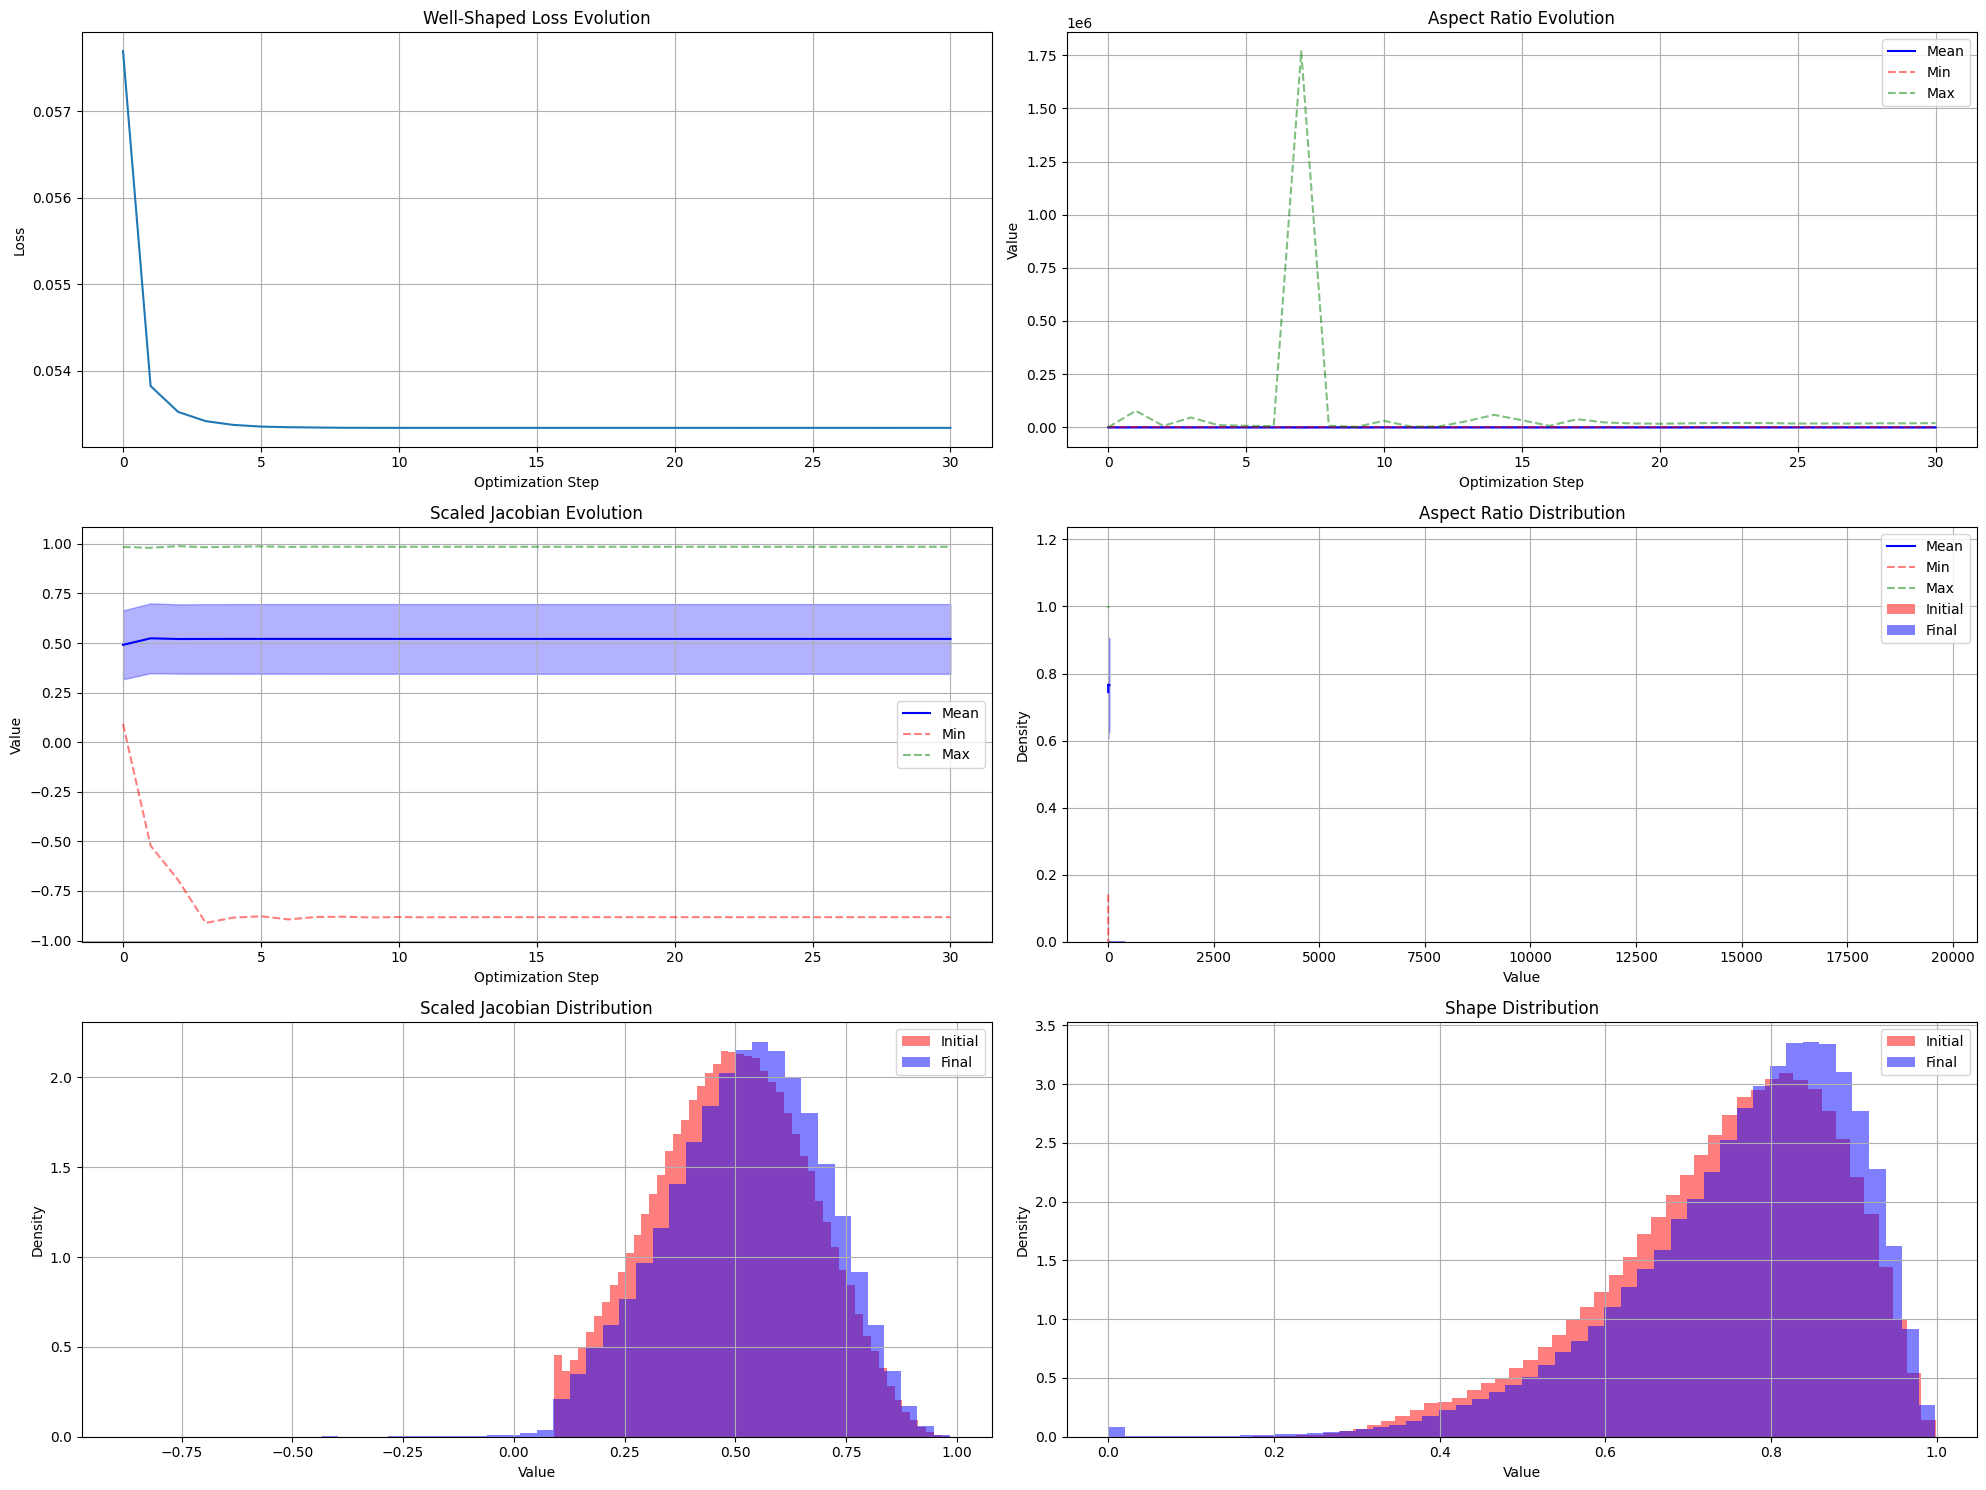

In [33]:
# Load and process the mesh
points = np.load("/home/ngaggion/DATA/HybridGNet3D/Dataset/VolumetricFiles/vol_nodes.npy")


final_nodes, loss_history, quality_history = optimize_mesh(
    points, tets, index_a, index_b, num_steps=301, lr=0.01
)